In [1]:
import pandas as pd # moduels used for project
import numpy as np
import os
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.cluster import KMeans
from env import get_db_url
from math import sqrt

import seaborn as sns
import matplotlib.pyplot as plt
import wrangle as w
import explore as exp
from wrangle import clean_zillow
from wrangle import create_features
from wrangle import train_validate_test_split
# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
import model
from model import  select_kbest
# Vis imports to make things look pretty 
import graphviz
from sklearn.tree import export_graphviz
import matplotlib.style as style 
style.available
style.use('seaborn-talk') #sets the size of the charts
style.use('seaborn-colorblind') #sets color of charts
from wrangle import wrangle_zillow


# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
def Standard_Scaler(X_train, X_validate, X_test): # used as a follow Function
    """
    Takes in X_train, X_validate and X_test dfs with numeric values only
    Returns scaler, X_train_scaled, X_validate_scaled, X_test_scaled dfs
    """
    scaler = sklearn.preprocessing.StandardScaler().fit(X_train)
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), index = X_train.index, columns = X_train.columns)
    X_validate_scaled = pd.DataFrame(scaler.transform(X_validate), index = X_validate.index, columns = X_validate.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), index = X_test.index, columns = X_test.columns)
    return scaler, X_train_scaled, X_validate_scaled, X_test_scaled

In [3]:
def explore_univariate_quant(train, quant_var): # used as a follow Function
    '''
    takes in a dataframe and a quantitative variable and returns
    descriptive stats table, histogram, and boxplot of the distributions. 
    '''
    descriptive_stats = train[quant_var].describe()
    plt.figure(figsize=(8,2))

    p = plt.subplot(1, 2, 1)
    p = plt.hist(train[quant_var], color='maroon')
    p = plt.title(quant_var)

    # second plot: box plot
    p = plt.subplot(1, 2, 2)
    p = plt.boxplot(train[quant_var])
    p = plt.title(quant_var)
    return p, descriptive_stats

In [4]:
def explore_univariate(train, cat_vars, quant_vars): # used as a follow Function
    for var in cat_vars:
        explore_univariate_categorical(train, var)
        print('_________________________________________________________________')
    for col in quant_vars:
        p, descriptive_stats = explore_univariate_quant(train, col)
        plt.show(p)
        print(descriptive_stats)
        
def explore_bivariate(train, target, cat_vars, quant_vars):
    for cat in cat_vars:
        explore_bivariate_categorical(train, target, cat)
    for quant in quant_vars:
        explore_bivariate_quant(train, target, quant)

def explore_multivariate(train, target, cat_vars, quant_vars):
    '''
    '''
    plot_swarm_grid_with_color(train, target, cat_vars, quant_vars)
    plt.show()
    violin = plot_violin_grid_with_color(train, target, cat_vars, quant_vars)
    plt.show()
    pair = sns.pairplot(data=train, vars=quant_vars, hue='target')
    plt.show()
    plot_all_continuous_vars(train, 'target', quant_vars)
    plt.show()    


In [5]:
def train_validate_test_split(df, target, seed): # used as a follow Function
    '''
    spilts our data  into train, validate, test
    '''
    # Train, Validate, and test
    train_and_validate, test = train_test_split(
        df, test_size=0.2, random_state=seed)
    train, validate = train_test_split(
        train_and_validate,
        test_size=0.3,
        random_state=seed)
    # Split with X and y
    X_train = train.drop(columns=[target])
    y_train = train[target]
    X_validate = validate.drop(columns=[target])
    y_validate = validate[target]
    X_test = test.drop(columns=[target])
    y_test = test[target]
    return train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test  

In [6]:
def select_kbest(X, y, n): # used as a follow Function
    '''
    select_kbest takes in the 
    predictors (X), 
    the target (y), and 
    the number of features to select (k) and 
    returns the names of the top k selected features based on the SelectKBest class
    '''
    
    # parameters: f_regression stats test
    f_selector = SelectKBest(f_regression, k= n)
    
    # find the top 2 X-feats correlated with y
    f_selector.fit(X, y)
    
    # boolean mask of whether the column was selected or not. 
    feature_mask = f_selector.get_support()
    
    # get list of top K features. 
    f_feature = X.iloc[:,feature_mask].columns.tolist()
    
    return f_feature

In [7]:
def correlation_test(nullh, alth, x, y): # used as a follow Function 
    '''
    correlation_test will take in two arguments and 
    - plot a scatterplot of them
    - test the correlation
    return: the correlation coefficient, p, and if there is a linear relationship.
    '''
    
    splot = plt.scatter(x, y, cmap = 'Purples', c='maroon' )
    
    null_hypothesis = nullh
    alternative_hypothesis = alth
    
    confidence_level = .95
    a = 1 - confidence_level 
    
    corr, p = stats.pearsonr(x, y)

    if p < a:
        print(f"Reject null statment: {null_hypothesis}")
        print("There is a linear relationship.")
        if 0 < corr < .6:
            print("Although, it is a positive weak one.")
        elif .6 < corr < 1:
            print("That is a stronger positive correlation.")
        elif -.6 < corr < 0:
            print("Although, it is a negative weak one.")
        elif -1 < corr < -.6:
            print("That is a stronger negative correlation.")
        
    else : 
        print("Fail to reject the null hypothesis.")
        
    print(f"""
    Correlation Coefficient: {corr}
    p: {p}
    
    """)
    return splot

In [8]:
def rfe(X, y, n): # used as a follow Function 
    '''
    rfe takes in the 
    predictors (X), 
    the target (y), and 
    the number of features to select (k) and 
    returns the names of the top k selected features based on the SelectKBest class
    '''
    
    # initialize the ML algorithm
    lm = LinearRegression()
    
    # create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
    rfe = RFE(lm, n)
    
    # fit the data using RFE
    rfe.fit(X,y)  
    
    # get the mask of the columns selected
    feature_mask = rfe.support_
    
    # get list of the column names. 
    rfe_feature = X.iloc[:,feature_mask].columns.tolist()
    
    return rfe_feature

## Joseph Goerner 
## 06/20/2022

<img src="stampede.tif"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 20px;" />

# <em> In the Event of Clustering use the Elbow Method !!!</em>

___
<div class="alert alert-block alert-warning">   <span style="color:maroon;">

    


<h3> <span style="color:maroon;">
<h3> Executive Summary: </span> </h3>  
<h3><span style="color:maroon;">Project Goals- To identify drivers of error in the Zestimate in order to improve accuracy of predicting home values, with the help of Ml and clustering models. </h3>

>`logerror` = log (Zestimate) − log (ActualSalePrice)  

<h3><span style="color:maroon;">In this presention I will attack and perform the heavy proccess of Cluster analysis on the logerror values from the year of 2017, to predict future homeprices. I will also be searching for the key drives of logerror, This turned out to be </h3>   
    


  <span style="color:black;">   

- 'sqft',
-'lot_sqft',
- 'bedrooms',
- 'bathrooms',
- 'structure_dollar_per_sqft',
- 'land_dollar_per_sqft',
- 'poor_quality_old_age',
- 'avq_quality_young_age'
-'longitude'
    </span>
<h3><span style="color:maroon;"> I created a ols regressor model with a %0.0003 effective improvement over my baseline so I as a data scientist would recommend further analysis with my model.</h3> 

BASELINE:
              
              RMSE using Median
              Train/In-Sample: 0.164122
              Validate/Out-of-Sample: 0.166928
              
              
    RMSE for OLS using LinearRegression
    
    Test/Out-of-Sample Performance: 0.161775
    
##  FIPS 
<span style="color:black;">

* Los Angeles County, California (6037)
* Orange County, California (6059)
* Ventura County, California (6111)
  
# <span style="color:maroon;"> Hypotheses </span>

1.Fail to reject the null hypothesis // home_age and logerror.
There is a linear relationship.
Although, it is a negative weak one.
    
2.Reject null statment: No correlation between lot_sqft and logerror.
There is a linear relationship.
Although, it is a positive weak one.

3.Fail to reject the null hypothesis // No correlation between home_value and logerror.

    
    
-LA:  0.014516765820273388

-Orange:  0.01786707488534417

-Ventura: 0.013923148212340804 

4. All three counties rejected the null hypothiesis






    
    

    
 










<div class="alert alert-block alert-warning">    

<span style="color:maroon;"> 
    <div class="alert alert-block alert-warning">    
<span style="color:maroon;"> <strong>

Events in sequence 
1. Import 
2. Acquire Data
3. Clean, Prep and Split Data
4. Explore Data 
 * Hypothesis Testing
6. Evaluation of Data 
7. Modeling
 * Mvp, Identify Baseline 
 * Train and Validate 
 * We Test our best 
8. Conclusion and Recomindations 
</span>
</div>
</strong>

___
<div class="alert alert-block alert-warning">   <span style="color:maroon;">

# 1. Acquire
    
<span style="color:black;">    
    
 We need to Acquire the Data from the Sql so that we can work with it, we use a env file with our passwords saved in it and the original file had  77574 rows and 68 columns. Alot to clean and prep 

In [9]:
df = w.zillow17() # data file 

In [10]:
df.info() # info on data file 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77574 entries, 0 to 77573
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77574 non-null  int64  
 1   parcelid                      77574 non-null  int64  
 2   airconditioningtypeid         25006 non-null  float64
 3   architecturalstyletypeid      206 non-null    float64
 4   basementsqft                  50 non-null     float64
 5   bathroomcnt                   77574 non-null  float64
 6   bedroomcnt                    77574 non-null  float64
 7   buildingclasstypeid           15 non-null     float64
 8   buildingqualitytypeid         49808 non-null  float64
 9   calculatedbathnbr             76959 non-null  float64
 10  decktypeid                    614 non-null    float64
 11  finishedfloor1squarefeet      6035 non-null   float64
 12  calculatedfinishedsquarefeet  77374 non-null  float64
 13  f

____

## Clean, Prep and Split the data <span style="color:maroon;">  
 ### <span style="color:maroon;">  I have tied alot of these functions in my wrangle w. py folder so it can look streamlined but the functions that where used are </span> 
 <div class="alert alert-block alert-warning"></b>   

- [`clean_zillow()`](wrangle.py)
- [`zillow17()`](wrangle.py)
- [`split_zillow`](wrangle.py)
- [`wrangle_zillow`](wrangle.py)
** <span style="color:maroon;">
<b>Prepare Summary:</b> <span style="color:maroon;"></b> 
<br>-  <b>Dropped: </b> <br><span style="color:maroon;"></b> 
</b> <span style="color:maroon;">- 45 columns and 4323 rows</b> </b> 
<br>- <b>WHY DID I DROP ?! </b> 
<br>I dropped nulls columns that had more then 60% of nulls and dropped rows that had 70% of nulls because I could not get the missing information from other variables or impute the missing values without high skew or other problems.I also dropped columns that contained information that was repeated or was not usefull and dropped columns that contained information I would not be using in our models.
<br><b>Outliers: </b> <br>
    
 <span style="color:maroon;"><br><b>I handled outliers in taxvaluedollarcnt by dropping values more then $5 million
<br>- I handled outliers in calculatedfinishedsquarefeet by dropping values less then 500 sqft and more then 12500 sqft
<br>- <b>Remaining missing values:</b> <br>
 <span style="color:maroon;">- lotsizesquarefeet missing values were filled with median numbers 
<span style="color:maroon;"><br>- buildingqualitytypeid missing values were filled with median numbers 
<br>- remaining missing values were dropped as they where not usefull
<br>- <b>Renamed columns: </b> <br>
 <span style="color:maroon;">- 9 columns renamed to accurately represent the data they contain for ease and sanity 
<br>- Ex). calculatedfinishedsquarefeet to sqft 
<br>- <b>New features: </b> </b>
</b> <span style="color:maroon;">- </b> New features created: home_age, county, logerror_quartiles</b>
<br>-<b>Split:</b>
<br>- dataset was split into 70% Train, 20% Validate, 10% Test<br>
</div> 
</span>  

In [11]:
df = w.wrangle_zillow() # wrangle file with requirments in it 

In [12]:
df.info() #  Info on data file 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71818 entries, 14297519 to 12826780
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Unnamed: 0              71818 non-null  int64   
 1   bathrooms               71818 non-null  float64 
 2   bedrooms                71818 non-null  int64   
 3   property_quality        71818 non-null  int64   
 4   sqft                    71818 non-null  float64 
 5   fips                    71818 non-null  int64   
 6   latitude                71818 non-null  float64 
 7   longitude               71818 non-null  float64 
 8   lot_sqft                71818 non-null  float64 
 9   rawcensustractandblock  71818 non-null  float64 
 10  regionidcity            71818 non-null  float64 
 11  zip_code                71818 non-null  int64   
 12  roomcnt                 71818 non-null  int64   
 13  unitcnt                 71818 non-null  int64   
 14  yearbuilt   

In [13]:
dummies = pd.get_dummies(df.county)  # created dummy files 
dummies.columns = ['LA', 'Orange', 'Ventura']
df = pd.concat([df, dummies], axis=1)

In [14]:
# new names for colums in my new df file 
new = df[['LA', 'Orange', 'Ventura','fips','latitude', 'longitude', 'sqft', 'lot_sqft', 'zip_code', 'property_quality', 'home_age', 'logerror', 'structure_value', 'bedrooms' , 'bathrooms' , 'land_value']].copy()

In [15]:
# Spliting the data 
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = train_validate_test_split(new, 'logerror', 123)

In [16]:
# adding Features to my data 

train['structure_dollar_per_sqft'] = train.structure_value / train.sqft
train['land_dollar_per_sqft'] = train.land_value / train.lot_sqft
train['bed_bath_ratio'] = train.bedrooms / train.bathrooms

In [17]:
# adding Features to my data 
df['structure_dollar_per_sqft'] = df.structure_value / df.sqft
df['land_dollar_per_sqft'] = df.land_value / df.lot_sqft
df['bed_bath_ratio'] = df.bedrooms / df.bathrooms

In [18]:
# adding Features to my data 
new['structure_dollar_per_sqft'] = df.structure_value / df.sqft
new['land_dollar_per_sqft'] = df.land_value / df.lot_sqft
new['bed_bath_ratio'] = df.bedrooms / df.bathrooms

___
<div class="alert alert-block alert-warning">  <span style="color:maroon;">
    
# Exploring The Clean Data

    
<span style="color:black;">

1.Question what are the skews of my explored data 

    
2. are Fips relevant to the issue of logerror 

    
3. is there anything that stands out in property_quality 

    
4. is there anything that stands out in home_age 


In [19]:
# scaling the data 
scaler, X_train_scaled, X_validate_scaled, X_test_scaled = Standard_Scaler(X_train, X_validate, X_test)

In [20]:
# using this to orginize and make columes to explore the data 

binary_vars = ['LA', 'Orange', 'Ventura']
cat_vars = []
quant_var = ['fips', 'latitude', 'longitude', 'sqft',
       'lot_sqft', 'zip_code', 'property_quality', 'home_age','structure_value', 'bedrooms' , 'bathrooms' , 'land_value'
            ,'structure_dollar_per_sqft', 'land_dollar_per_sqft', 'bed_bath_ratio' ]
continuous_target = 'logerror'
categorical_target = 'logerror'

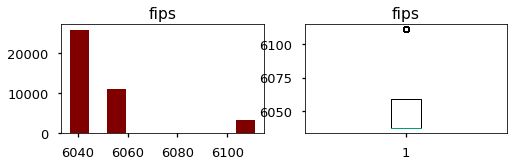

count    40217.000000
mean      6049.276351
std         21.040147
min       6037.000000
25%       6037.000000
50%       6037.000000
75%       6059.000000
max       6111.000000
Name: fips, dtype: float64


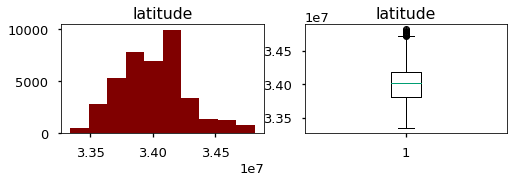

count    4.021700e+04
mean     3.400741e+07
std      2.671053e+05
min      3.333953e+07
25%      3.381196e+07
50%      3.402078e+07
75%      3.417650e+07
max      3.481877e+07
Name: latitude, dtype: float64


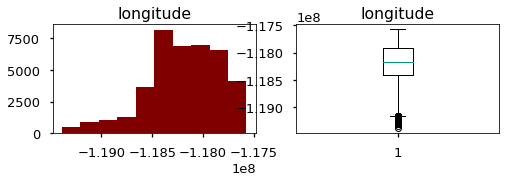

count    4.021700e+04
mean    -1.181994e+08
std      3.639335e+05
min     -1.193883e+08
25%     -1.184165e+08
50%     -1.181671e+08
75%     -1.179168e+08
max     -1.175728e+08
Name: longitude, dtype: float64


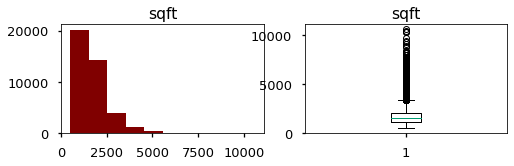

count    40217.000000
mean      1733.628714
std        861.174436
min        501.000000
25%       1171.000000
50%       1507.000000
75%       2044.000000
max      10605.000000
Name: sqft, dtype: float64


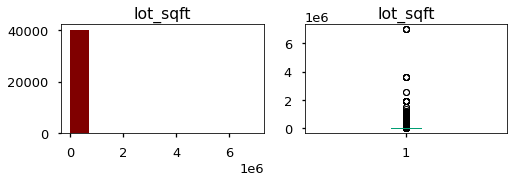

count    4.021700e+04
mean     2.816415e+04
std      1.253648e+05
min      2.360000e+02
25%      5.983000e+03
50%      7.265000e+03
75%      1.058800e+04
max      6.971010e+06
Name: lot_sqft, dtype: float64


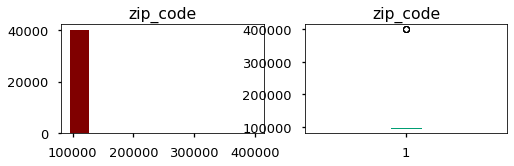

count     40217.000000
mean      96586.871298
std        3050.899556
min       95982.000000
25%       96208.000000
50%       96410.000000
75%       96989.000000
max      399675.000000
Name: zip_code, dtype: float64


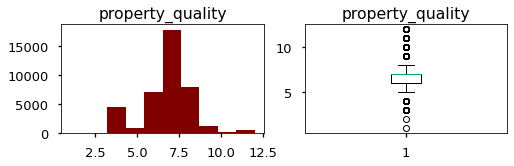

count    40217.000000
mean         6.753637
std          1.346508
min          1.000000
25%          6.000000
50%          7.000000
75%          7.000000
max         12.000000
Name: property_quality, dtype: float64


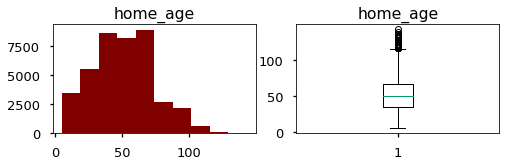

count    40217.000000
mean        51.419673
std         22.929058
min          5.000000
25%         34.000000
50%         50.000000
75%         67.000000
max        143.000000
Name: home_age, dtype: float64


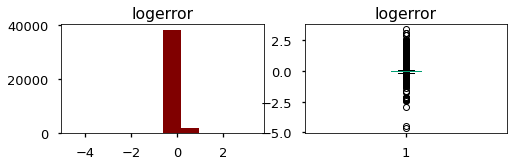

count    40217.000000
mean         0.015390
std          0.162298
min         -4.655420
25%         -0.023779
50%          0.006473
75%          0.037751
max          3.394544
Name: logerror, dtype: float64


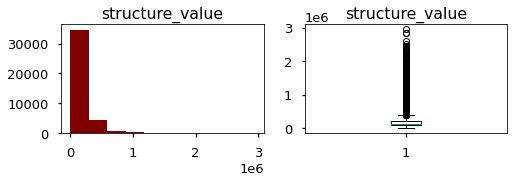

count    4.021700e+04
mean     1.813101e+05
std      1.783296e+05
min      1.480000e+02
25%      8.400000e+04
50%      1.347120e+05
75%      2.139880e+05
max      2.943209e+06
Name: structure_value, dtype: float64


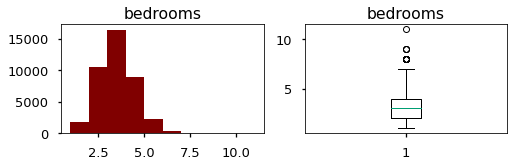

count    40217.000000
mean         3.008852
std          0.989914
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         11.000000
Name: bedrooms, dtype: float64


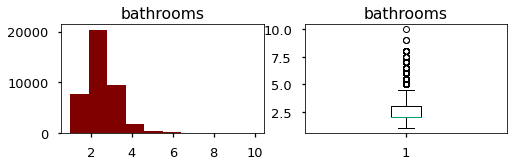

count    40217.000000
mean         2.269053
std          0.914743
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         10.000000
Name: bathrooms, dtype: float64


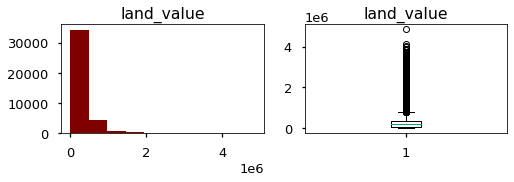

count    4.021700e+04
mean     2.837746e+05
std      3.265030e+05
min      1.196000e+03
25%      8.338700e+04
50%      2.030890e+05
75%      3.620000e+05
max      4.847224e+06
Name: land_value, dtype: float64


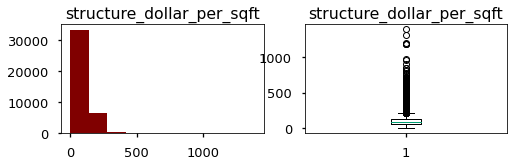

count    40217.000000
mean        99.532276
std         59.399594
min          0.039833
25%         63.079227
50%         91.724350
75%        124.075276
max       1386.370588
Name: structure_dollar_per_sqft, dtype: float64


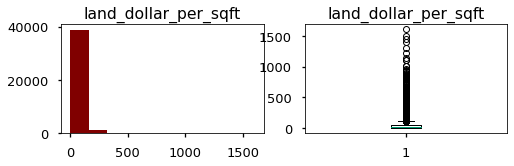

count    40217.000000
mean        41.055693
std         60.780846
min          0.003805
25%          6.341829
50%         25.492223
75%         51.983493
max       1604.525311
Name: land_dollar_per_sqft, dtype: float64


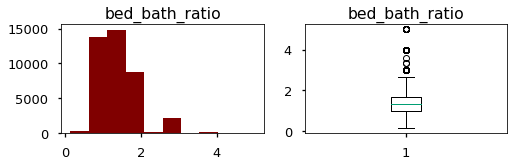

count    40217.000000
mean         1.450311
std          0.565171
min          0.133333
25%          1.000000
50%          1.333333
75%          1.666667
max          5.000000
Name: bed_bath_ratio, dtype: float64


In [21]:
# using this to orginize and make columes to explore the data
cat_vars = []
quant_vars = ['fips', 'latitude', 'longitude', 'sqft',
       'lot_sqft', 'zip_code', 'property_quality', 'home_age', 'logerror','structure_value', 'bedrooms' , 'bathrooms' , 'land_value','structure_dollar_per_sqft', 'land_dollar_per_sqft', 'bed_bath_ratio']

explore_univariate(train, cat_vars, quant_vars)

___
<div class="alert alert-block alert-warning">   <span style="color:maroon;">

# Information From Generated Graphs: 
<span style="color:black;">

    
- fips has a right skew, with the tip at LA
- Latitude is centered, probably not that important 
- Longitude has a left skew 
- sqft has a right skew 
- Hard to tell but i think lot_sqft will have a right skew  
- Zip code hard to tell still graph may be right skew 
- property_quality center 
- Home_age is a right skew 
- Logerror is center 
- Structure_value is a right skew 
- Bedrooms looks to be right skew 
- Bathrooms looks to be right skew 
- Land_value is a right skew 
- structure_dollar_per_sqft looks to be right skew 
- land_dollar_per_sqft is slim but probably is a right skew 
- bed_bath_ratio is a right skew 

<AxesSubplot:xlabel='latitude', ylabel='logerror'>

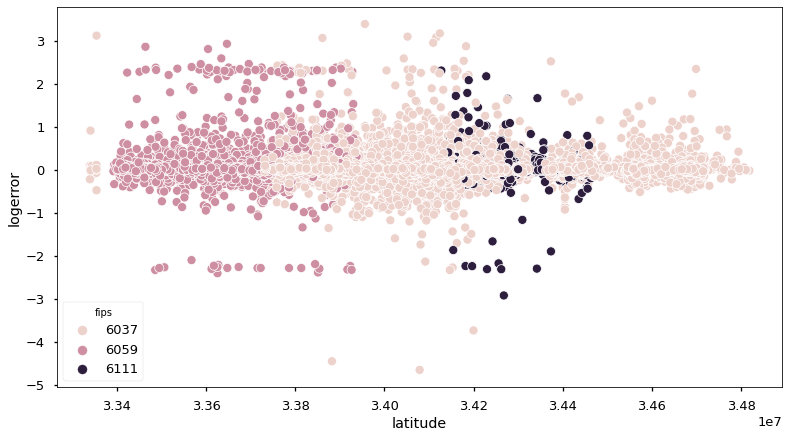

In [22]:
# plot for latitude 
plt.figure(figsize=(13, 7))
sns.scatterplot(data=new, x='latitude', y='logerror', hue='fips')

<AxesSubplot:xlabel='longitude', ylabel='logerror'>

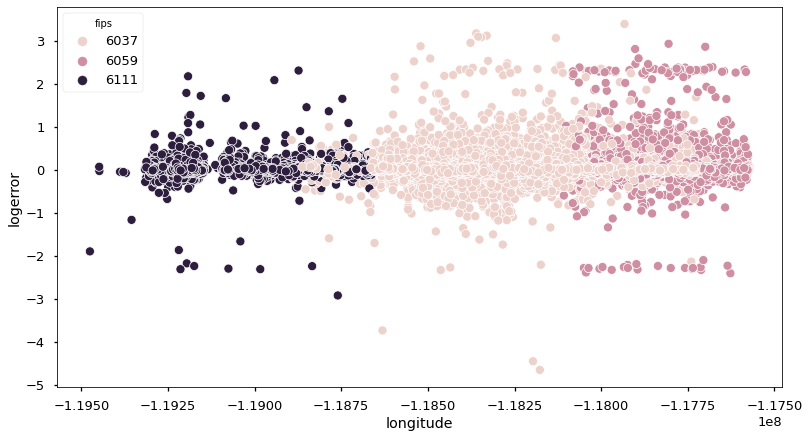

In [23]:
# plot for longitude 
plt.figure(figsize=(13, 7))
sns.scatterplot(data=new, x='longitude', y='logerror', hue='fips')

<AxesSubplot:xlabel='latitude', ylabel='logerror'>

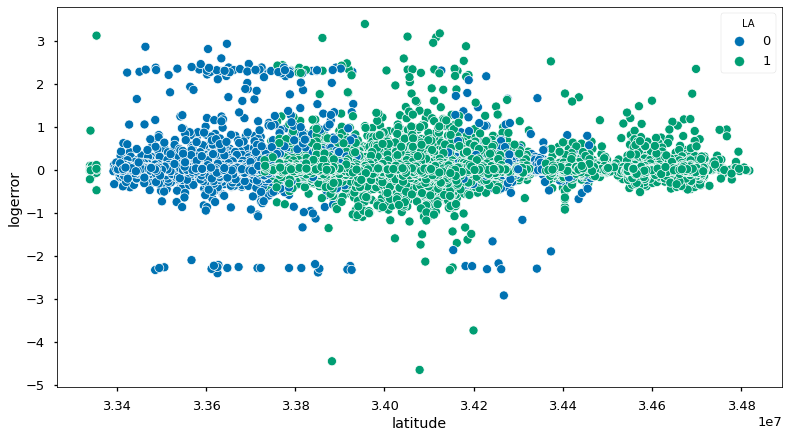

In [24]:
# Hue LA, latitude plot 
plt.figure(figsize=(13, 7))
sns.scatterplot(data=new, x='latitude', y='logerror', hue='LA')

<AxesSubplot:xlabel='latitude', ylabel='logerror'>

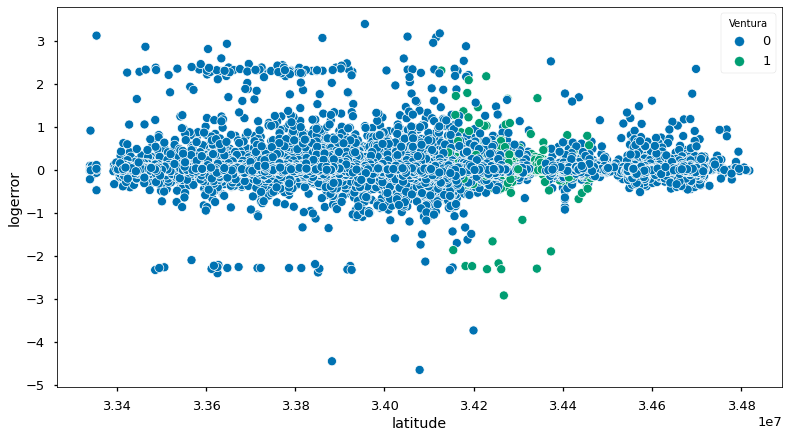

In [25]:
# Hue ventura, Latitude plot 
plt.figure(figsize=(13, 7))
sns.scatterplot(data=new, x='latitude', y='logerror', hue='Ventura')

<AxesSubplot:xlabel='latitude', ylabel='logerror'>

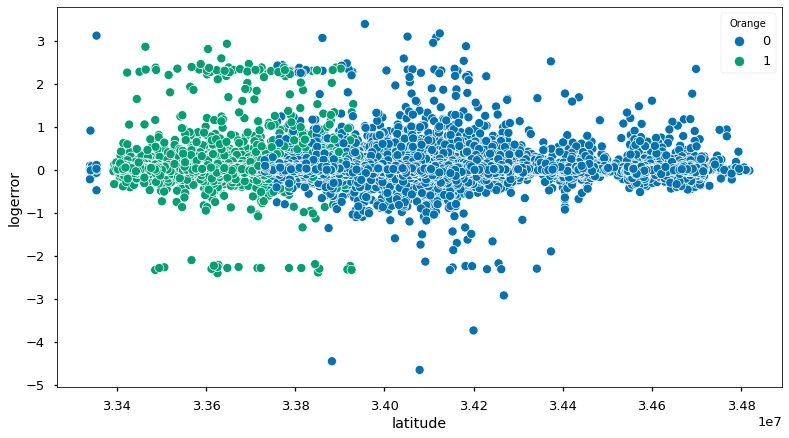

In [26]:
# hue Orange , Latitude plot 
plt.figure(figsize=(13, 7))
sns.scatterplot(data=new, x='latitude', y='logerror', hue='Orange')

<AxesSubplot:xlabel='property_quality', ylabel='logerror'>

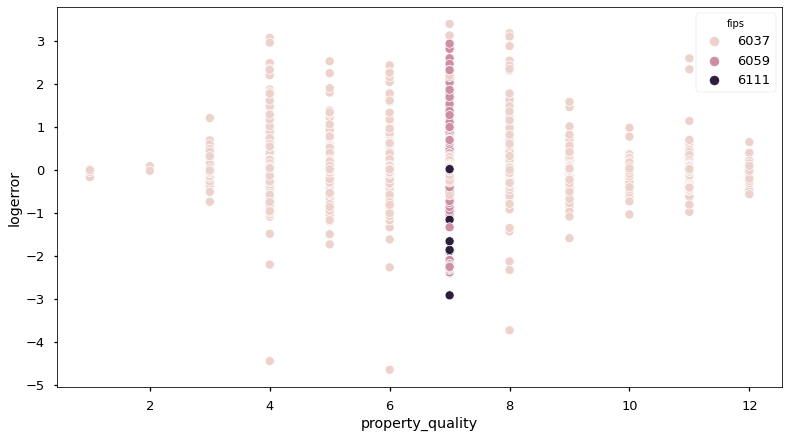

In [27]:
# property Quality and Fips plot 
plt.figure(figsize=(13, 7))
sns.scatterplot(data=new, x='property_quality', y='logerror', hue='fips')

<AxesSubplot:xlabel='home_age', ylabel='fips'>

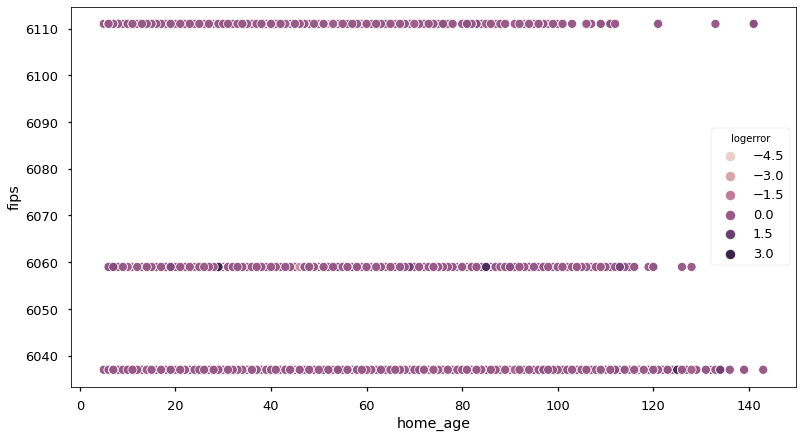

In [28]:
# Hue logerror and home_age plot 
plt.figure(figsize=(13, 7))
sns.scatterplot(data=new, x='home_age', y='fips', hue='logerror')

___

<div class="alert alert-block alert-warning">   <span style="color:maroon;">



# Hypotheses testing 
<span style="color:black;">

1.Fail to reject the null hypothesis // home_age and logerror.
There is a linear relationship.
Although, it is a negative weak one.
    
2.Reject null statment: No correlation between lot_sqft and logerror.
There is a linear relationship.
Although, it is a positive weak one.

3.Fail to reject the null hypothesis // No correlation between home_value and logerror.

4. All three counties rejected the null hypothiesis



- Is logerror diffrent in each county 
- Properties of LA vs Orange 
- Properties of LA vs Ventura 
- Properties of Orange vs Ventura 
    
    
-LA:  0.014516765820273388

-Orange:  0.01786707488534417

-Ventura: 0.013923148212340804 




In [29]:
#assign your null hypothesis
nullh = "No correlation between home_age and logerror."

#and your alternative hypothesis
alth = "There IS a correlation between home_age and logerror."

#the feature you are testing
x1 = X_train_scaled.home_age

#against your target
y1 = y_train

Fail to reject the null hypothesis.

    Correlation Coefficient: -0.009091686955585479
    p: 0.06826644862171057
    
    


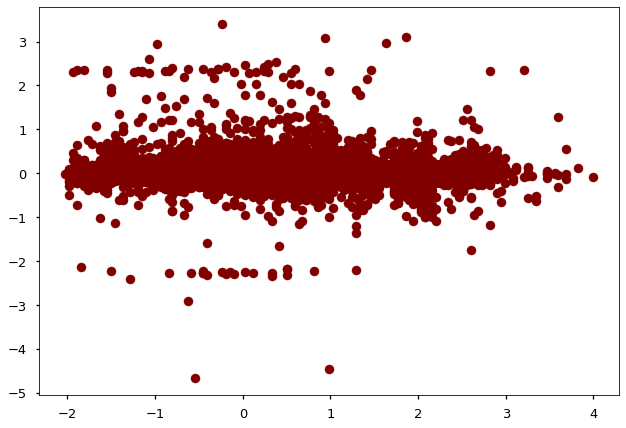

In [30]:
# Fail to reject the null hypothesis // home_age and logerror. There is a linear relationship. Although, it is a negative weak one.
correlation_test(nullh, alth, x1, y1)

In [31]:
#assign your null hypothesis
nullh = "No correlation between lot_sqft and logerror."

#and your alternative hypothesis
alth = "There IS a correlation between lot_sqft and logerror."

#the feature you are testing
x2 = X_train_scaled.lot_sqft

#against your target
y2 = y_train

Reject null statment: No correlation between lot_sqft and logerror.
There is a linear relationship.
Although, it is a positive weak one.

    Correlation Coefficient: 0.012872169213528831
    p: 0.009839073124819048
    
    


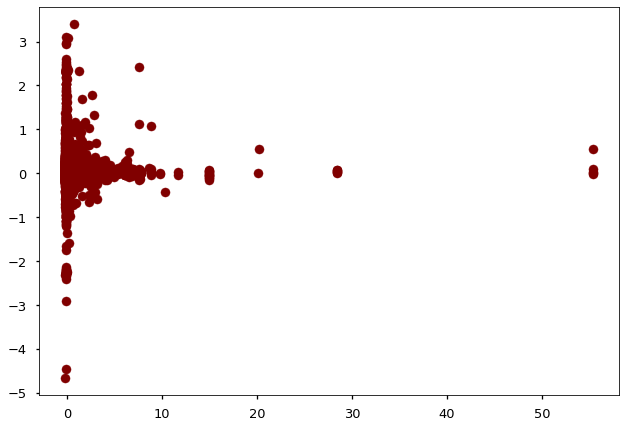

In [32]:
# .Reject null statment: No correlation between lot_sqft and logerror. There is a linear relationship. Although, it is a positive weak one.

correlation_test(nullh, alth, x2, y2)

In [33]:
#assign your null hypothesis
nullh = "No correlation between land_value and logerror."

#and your alternative hypothesis
alth = "There IS a correlation between land_value and logerror."

#the feature you are testing
x3 = X_train_scaled.land_value

#against your target
y3 = y_train

Fail to reject the null hypothesis.

    Correlation Coefficient: -0.002359023235530234
    p: 0.6361642093651477
    
    


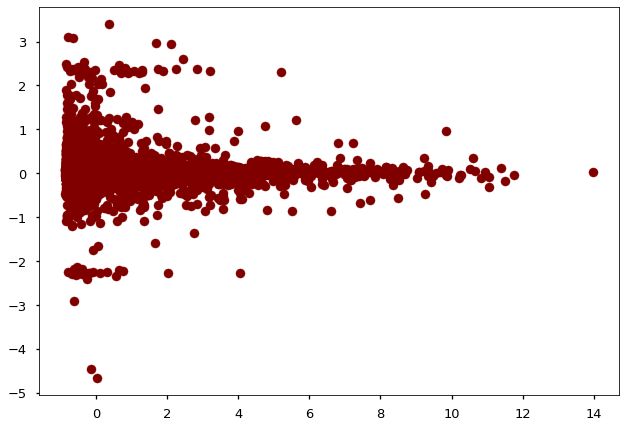

In [34]:
#Fail to reject the null hypothesis // No correlation between home_value and logerror.
correlation_test(nullh, alth, x3, y3)

In [35]:
#set confidence interval and alpha before the test
conf_interval = .95 # desired confidence interval
alpha = 1 - conf_interval

In [36]:
# putting .logerror in my train and dummy files 
LA = train[train.LA == 1].logerror
Orange = train[train.Orange == 1].logerror
Ventura = train[train.Ventura == 1].logerror

In [37]:
# checking means and orginization 
mean_log_la = LA.mean()
mean_log_orange = Orange.mean()
mean_log_ventura = Ventura.mean()

### What is the avrage logerror per county

In [38]:

# getting my What is the avrage logerror per county

print('LA: ', mean_log_la)
print('Orange: ', mean_log_orange)
print('Ventura:', mean_log_ventura)

LA:  0.014516765820273388
Orange:  0.01786707488534417
Ventura: 0.013923148212340804


In [39]:
#correlation test summary
def stat_summary(p):
    if p < alpha:
        print(f'Pvalue is: {p} is less than alpha: {alpha}')
        print("Reject the null hypothesis because there is a significant difference present")
    else:
        print(f'Pvalue is: {p} is greater than alpha: {alpha}')
        print("We fail to reject the null hypothesis because there is no significant difference present")

In [40]:
t, p = stats.ttest_ind(LA, Orange, equal_var=False)

## Logerror vs LA and Ventura County 

In [41]:
t, p # looking at testing numbers 

(-1.7031191104734367, 0.08856271829227355)

In [42]:
stat_summary(p) # Pvalue is: 0.08856271829227355 is greater than alpha: 0.050000000000000044
#We fail to reject the null hypothesis because there is no significant difference present

Pvalue is: 0.08856271829227355 is greater than alpha: 0.050000000000000044
We fail to reject the null hypothesis because there is no significant difference present


In [43]:
t, p = stats.ttest_ind(LA, Ventura, equal_var=False) # # looking at testing numbers 
t,p

(0.20602286996960875, 0.8367828703309689)

In [44]:
stat_summary(p) # Pvalue is: 0.8367828703309689 is greater than alpha: 0.050000000000000044
 #We fail to reject the null hypothesis because there is no significant difference present


Pvalue is: 0.8367828703309689 is greater than alpha: 0.050000000000000044
We fail to reject the null hypothesis because there is no significant difference present


## Logerror vs Orange and Ventura County

In [45]:
t, p = stats.ttest_ind(Orange, Ventura, equal_var=False) #looking at testing numbers 
t,p

(1.2275702335554781, 0.21965415832601334)

In [46]:
stat_summary(p) # Pvalue is: 0.21965415832601334 is greater than alpha: 0.050000000000000044
 #We fail to reject the null hypothesis because there is no significant difference present

Pvalue is: 0.21965415832601334 is greater than alpha: 0.050000000000000044
We fail to reject the null hypothesis because there is no significant difference present


## All three counties fail to reject becuase there is no significant difference present 

___
<div class="alert alert-block alert-warning">   <span style="color:maroon;">

# Now we move into clustering, I have chosen to cluster: 
    
<span style="color:black;">

    
    
- home_age', 'sqft'
- 'property_quality', 'home_age'

In [47]:
# setting up to do elbow test with all requirments 
X = df[['home_age', 'sqft']]

scaler = sklearn.preprocessing.StandardScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])

k = 2

kmeans = KMeans(n_clusters= k)
kmeans.fit(X_scaled)
kmeans.inertia_

89334.69716030076

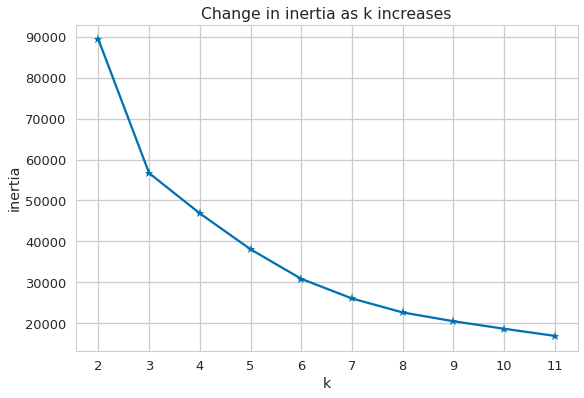

In [48]:
# ploting elbow test 
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_scaled).inertia_ for k in range(2, 12)}).plot(marker='*')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [49]:
# checking head of elbow test 
X = df[['home_age', 'sqft' ]]
X.head(2)

,home_age,sqft
parcelid,,
14297519,23,3100.0
17052889,54,1465.0


In [50]:
# scaler and fitting X
scaler = sklearn.preprocessing.StandardScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])

In [51]:
#define the thing
kmeans = KMeans(n_clusters=5)

# fit the thing
kmeans.fit(X_scaled)

# Use (predict using) the thing 
kmeans.predict(X_scaled)

array([2, 4, 4, ..., 4, 1, 1], dtype=int32)

In [52]:
# using X_scaled to kmeans.predict and creating cluster 
X_scaled['cluster'] = kmeans.predict(X_scaled)

In [53]:
# checking my array of cluster centers 
kmeans.cluster_centers_

array([[ 0.32112911,  0.68920924],
       [ 1.09252824, -0.52215971],
       [-1.25597363,  0.36641919],
       [-0.9475857 ,  2.78388792],
       [-0.38520328, -0.57923864]])

In [54]:
# checking centroids scaled 
centroids_scaled = pd.DataFrame(kmeans.cluster_centers_, columns = X.columns)
centroids_scaled

,home_age,sqft
0,0.321129,0.689209
1,1.092528,-0.522160
2,-1.255974,0.366419
3,-0.947586,2.783888
4,-0.385203,-0.579239


Text(0.5, 1.0, 'Visualizing Cluster Centers K = 5')

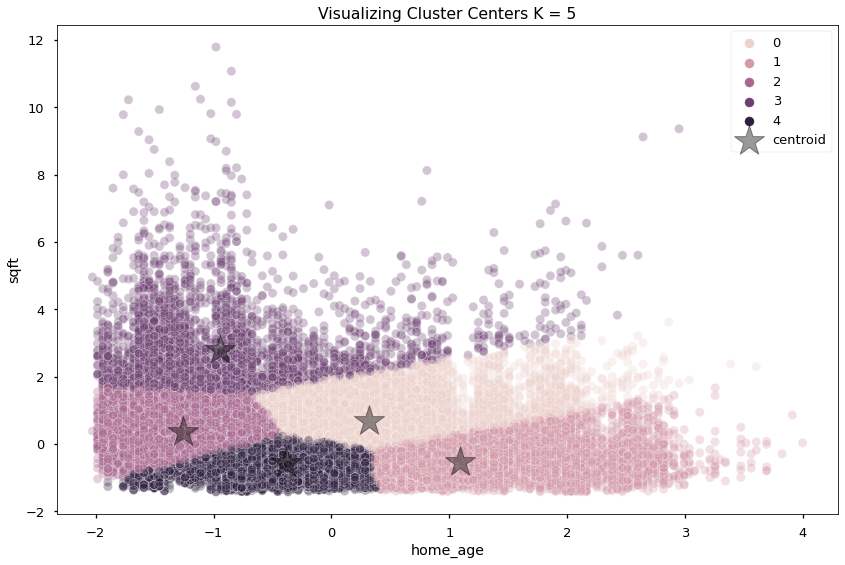

In [55]:
# Cluster center plot on sqft and home_age 

plt.figure(figsize=(14, 9))
sns.scatterplot(x='home_age', y = 'sqft', data = X_scaled,  hue = 'cluster' ,    alpha = 0.3 )
centroids_scaled.plot.scatter(y='sqft', x='home_age', c='k', marker='*', s=1000, ax=plt.gca(), alpha = 0.4, label='centroid', lw = 1)

plt.legend()

plt.title('Visualizing Cluster Centers K = 5')

___

<div class="alert alert-block alert-warning">   <span style="color:maroon;">


<em>

## When used in exploring i am seeing that clusters centers 0,1,2 are going to be the best observations to dig deeper into and use to help predict logerror

___
<div class="alert alert-block alert-warning">   <span style="color:maroon;">

## Property Quality and Home Age

In [56]:
X = df[['property_quality', 'home_age']]

scaler = sklearn.preprocessing.StandardScaler().fit(X)
X_scaled2 = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])

k = 4

kmeans = KMeans(n_clusters= k)
kmeans.fit(X_scaled)
kmeans.inertia_

59462.73843789999

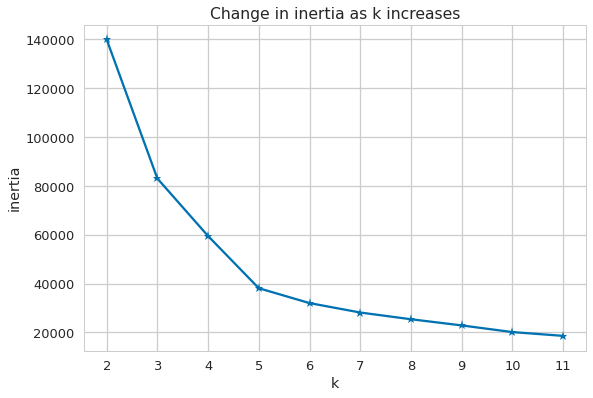

In [57]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_scaled).inertia_ for k in range(2, 12)}).plot(marker='*')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [58]:
X = df[['property_quality', 'home_age']]
X.head(2)

,property_quality,home_age
parcelid,,
14297519,7,23
17052889,7,54


In [59]:
scaler = sklearn.preprocessing.StandardScaler().fit(X)
X_scaled2 = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])

In [60]:
#define the thing
kmeans = KMeans(n_clusters=5)

# fit the thing
kmeans.fit(X_scaled2)

# Use (predict using) the thing 
kmeans.predict(X_scaled2)

array([0, 2, 2, ..., 2, 3, 1], dtype=int32)

In [61]:
df['pqha_cluster'] = kmeans.predict(X_scaled2)
X_scaled2['pqha_cluster'] = kmeans.predict(X_scaled2)

In [62]:
kmeans.cluster_centers_

array([[ 0.28561532, -1.09572216],
       [-0.2519731 ,  0.98030857],
       [ 0.38130921,  0.00815643],
       [-1.94429349,  1.25035872],
       [ 2.21631286, -0.75981856]])

In [63]:
centroids_scaled = pd.DataFrame(kmeans.cluster_centers_, columns = X.columns)
centroids_scaled

,property_quality,home_age
0,0.285615,-1.095722
1,-0.251973,0.980309
2,0.381309,0.008156
3,-1.944293,1.250359
4,2.216313,-0.759819


Text(0.5, 1.0, 'Visualizing Cluster Centers K = 5')

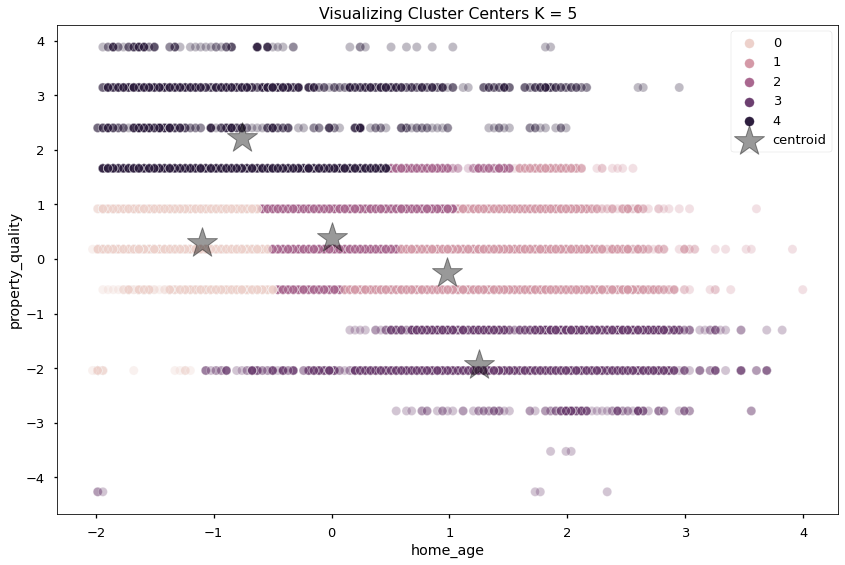

In [64]:
plt.figure(figsize=(14, 9))
sns.scatterplot(x='home_age', y = 'property_quality', data = X_scaled2, hue = 'pqha_cluster',  alpha = 0.3 )
centroids_scaled.plot.scatter(y='property_quality', x='home_age', color ='k', marker='*', s=1000, ax=plt.gca(), alpha = 0.4, label='centroid', lw = 1)

plt.legend()

plt.title('Visualizing Cluster Centers K = 5')

____
<div class="alert alert-block alert-warning"> <span style="color:maroon;">


<em>       
    
# This is still grouped and clustered with the most interesting being 1,2,3 I will hunt down these cluster centers to help predict logerror



____
<div class="alert alert-block alert-warning">   <span style="color:maroon;">




# I will Encode the Features 
    
 <span style="color:black;">   

-"homeagexquality_cluster_0": "avgqualityavgage", 

-"homeagexquality_cluster_1": "poor_quality_old_age", 

-"homeagexquality_cluster_2": "avq_quality_young_age", 

-"homeagexquality_cluster_3": "avg_quality_old_age", 

-"homeagexquality_cluster_4": "bestest"

In [65]:
cluster_df = pd.concat([X_scaled, X_scaled2], axis= 1)

In [66]:
cluster_df = pd.concat([new, cluster_df], axis= 1)

In [67]:
cluster_dummies = pd.get_dummies(cluster_df.cluster, prefix='homeagexquality')

In [68]:
cluster_dummies.rename(columns={"homeagexquality_cluster_0": "avgqualityavgage", "homeagexquality_cluster_1": "poor_quality_old_age", "homeagexquality_cluster_2": "avq_quality_young_age", "homeagexquality_cluster_3": "avg_quality_old_age", "homeagexquality_cluster_4": "bestest"})

,homeagexquality_0,homeagexquality_1,homeagexquality_2,homeagexquality_3,homeagexquality_4
14297519,0,0,1,0,0
17052889,0,0,0,0,1
14186244,0,0,0,0,1
12177905,1,0,0,0,0
10887214,0,0,0,0,1
...,...,...,...,...,...
10833991,0,0,0,0,1
11000655,0,1,0,0,0
17239384,0,0,0,0,1
12773139,0,1,0,0,0


In [69]:
df1 = pd.concat([cluster_df, cluster_dummies], axis=1)

In [70]:
df1.rename(columns={"homeagexquality_0": "avgqualityavgage", "homeagexquality_1": "poor_quality_old_age", "homeagexquality_2": "avq_quality_young_age", "homeagexquality_3": "avg_quality_old_age", "homeagexquality_4": "bestest"})

,LA,Orange,Ventura,fips,latitude,longitude,sqft,lot_sqft,zip_code,property_quality,...,sqft,cluster,property_quality,home_age,pqha_cluster,avgqualityavgage,poor_quality_old_age,avq_quality_young_age,avg_quality_old_age,bestest
14297519,0,1,0,6059,33634931.0,-117869207.0,3100.0,4506.0,96978,7,...,1.555025,2,0.178913,-1.241301,0,0,0,1,0,0
17052889,0,0,1,6111,34449266.0,-119281531.0,1465.0,12647.0,97099,7,...,-0.317152,4,0.178913,0.112154,2,0,0,0,0,1
14186244,0,1,0,6059,33886168.0,-117823170.0,1243.0,8432.0,97078,7,...,-0.571356,4,0.178913,0.330453,2,0,0,0,0,1
12177905,1,0,0,6037,34245180.0,-118240722.0,2376.0,13038.0,96330,8,...,0.726000,0,0.919541,-0.018826,2,1,0,0,0,0
10887214,1,0,0,6037,34185120.0,-118414640.0,1312.0,278581.0,96451,8,...,-0.492347,4,0.919541,0.243134,2,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10833991,1,0,0,6037,34202400.0,-118502000.0,1741.0,59487.0,96415,8,...,-0.001115,4,0.919541,-0.455424,2,0,0,0,0,1
11000655,1,0,0,6037,34245368.0,-118282383.0,1286.0,47405.0,96284,6,...,-0.522118,1,-0.561716,1.290970,1,0,1,0,0,0
17239384,0,0,1,6111,34300140.0,-118706327.0,1612.0,12105.0,97116,7,...,-0.148828,4,0.178913,0.243134,2,0,0,0,0,1
12773139,1,0,0,6037,34040895.0,-118038169.0,1032.0,5074.0,96480,4,...,-0.812964,1,-2.042972,0.679732,3,0,1,0,0,0


In [71]:
df = df1

In [72]:
df = df.drop(['cluster', 'pqha_cluster'], axis=1)

In [73]:
df = df.rename(columns={"homeagexquality_0": "avgqualityavgage", "homeagexquality_1": "poor_quality_old_age", "homeagexquality_2": "avq_quality_young_age", "homeagexquality_3": "avg_quality_old_age", "homeagexquality_4": "bestest"})

<div class="alert alert-block alert-warning">  <span style="color:maroon;">
    
# EDA: Answers !!! 

    
<span style="color:black;">

1.Question what are the skews of my explored data, this has been explained in the markdown of the graphsection 

    
2. are Fips relevant to the issue of logerror // I have not found any corrilation when it comes to logerror and fips  

    
3. is there anything that stands out in property_quality // Nothing stands out that is pointing in one specific direction 

    
4. is there anything that stands out in home_age // Nothing stands out that is pointing in one specific direction 





<div class="alert alert-block alert-warning">   <span style="color:maroon;">


### So in exploration we have explored a bunch of graphs and images that have given us a good idea, but really no smokeing gun, In my Hypotheses testing, almost everything rejected the null, only with small corrillations. My clustering made some good observations in home_age', 'sqft' and Property Quality and Home Age and gave me a good lead to follow through feature engineering and into modeling

___


<div class="alert alert-block alert-warning">   <span style="color:maroon;">




# Evaluation of the Data 

In [74]:
df.columns.to_list()

['LA',
 'Orange',
 'Ventura',
 'fips',
 'latitude',
 'longitude',
 'sqft',
 'lot_sqft',
 'zip_code',
 'property_quality',
 'home_age',
 'logerror',
 'structure_value',
 'bedrooms',
 'bathrooms',
 'land_value',
 'structure_dollar_per_sqft',
 'land_dollar_per_sqft',
 'bed_bath_ratio',
 'home_age',
 'sqft',
 'property_quality',
 'home_age',
 'avgqualityavgage',
 'poor_quality_old_age',
 'avq_quality_young_age',
 'avg_quality_old_age',
 'bestest']

In [75]:
numeric_cols = ['LA',
 'Orange',
 'Ventura',
 'fips',
 'latitude',
 'longitude',
 'sqft',
 'lot_sqft',
 'zip_code',
 'property_quality',
 'home_age',
 'logerror',
 'structure_value',
 'bedrooms',
 'bathrooms',
 'land_value',
 'structure_dollar_per_sqft',
 'land_dollar_per_sqft',
 'bed_bath_ratio',
 'home_age',
 'sqft',
 'property_quality',
 'home_age',
 'avgqualityavgage',
 'poor_quality_old_age',
 'avq_quality_young_age',
 'avg_quality_old_age',
 'bestest']

In [76]:
X_train, y_train, X_validate, y_validate, X_test, y_test = w.train_validate_test_split(df, "logerror", 6543)

In [77]:
scaler, X_train_scaled, X_validate_scaled, X_test_scaled = Standard_Scaler(X_train, X_validate, X_test)

<div class="alert alert-block alert-warning">   <span style="color:maroon;">




# Feature Engineering 
    
<span style="color:black;">
    
* We have added new encoded features and we will be testing out of top ten to see if any of our choices made it 

In [78]:
select_kbest(X_train_scaled, y_train, 10)

['longitude',
 'sqft',
 'lot_sqft',
 'bedrooms',
 'bathrooms',
 'structure_dollar_per_sqft',
 'land_dollar_per_sqft',
 'sqft',
 'avg_quality_old_age',
 'bestest']

____

<div class="alert alert-block alert-warning">   <span style="color:maroon;">





# So this is very interesting, 2 of our encoded values made the list:
    
    
<span style="color:black;">
    
-avgqualityavgage',

    
-'avg_quality_old_age'

<img src="modeling.tif"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 20px;" />

In [79]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

<div class="alert alert-block alert-warning">   <span style="color:maroon;">



## We are now going to see what our baseline is ??

In [80]:
# 1. compute pred_median
logerror_baseline_median = y_train['logerror'].median()
y_train['logerror_baseline_median'] = logerror_baseline_median
y_validate['logerror_baseline_median'] = logerror_baseline_median

# 2. compute pred_mean
logerror_baseline_mean = y_train['logerror'].mean()
y_train['logerror_baseline_mean'] = logerror_baseline_mean
y_validate['logerror_baseline_mean'] = logerror_baseline_mean

#check to see which is better
y_train.head()

,logerror,logerror_baseline_median,logerror_baseline_mean
14168996,0.009161,0.006644,0.015529
12518411,0.027330,0.006644,0.015529
14602445,-0.003372,0.006644,0.015529
17154690,-0.009766,0.006644,0.015529
11858352,0.304762,0.006644,0.015529


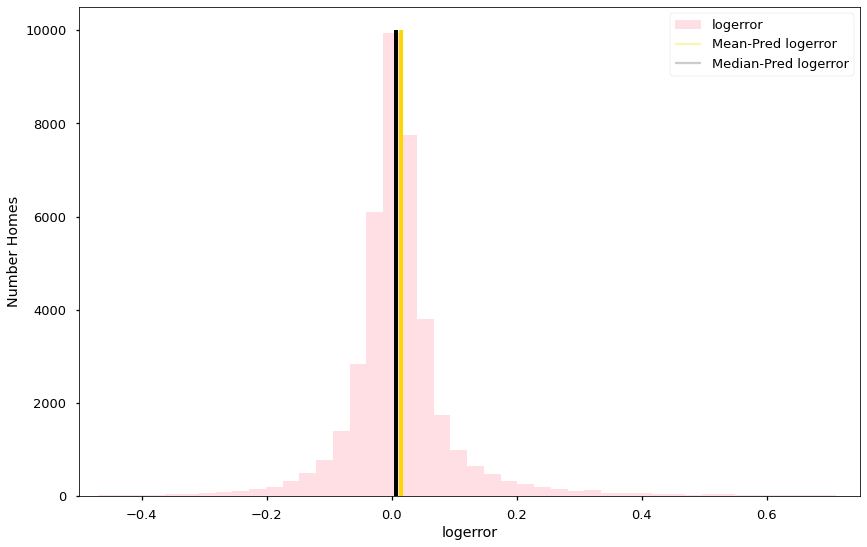

In [81]:
plt.figure(figsize=(14, 9))
plt.hist(y_train.logerror, color='pink', bins=300, alpha=.5, label="logerror")
plt.vlines(y_train.logerror_baseline_mean, 0, 10000, color='gold', alpha=.3, label="Mean-Pred logerror")
plt.vlines(y_train.logerror_baseline_median, 0, 10000, color='black', alpha=.2, label="Median-Pred logerror")
plt.xlim(-0.5, 0.75)
plt.xlabel("logerror")
plt.ylabel("Number Homes")
plt.legend()
plt.show()

<div class="alert alert-block alert-warning">   <span style="color:maroon;">




# I will push for the median Prediction becuase it is performing better 

In [82]:
# RMSE of logerror_pred_median
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_baseline_median) ** (0.5)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_baseline_median) ** (0.5)

print(f"""
      BASELINE:
      RMSE using Median
      Train/In-Sample: {round(rmse_train, 6)}
      Validate/Out-of-Sample: {round(rmse_validate, 6)}
        """)


      BASELINE:
      RMSE using Median
      Train/In-Sample: 0.164122
      Validate/Out-of-Sample: 0.166928
        


<div class="alert alert-block alert-warning">   <span style="color:maroon;">




# TRAIN AND VALIDATION 

<div class="alert alert-block alert-warning">      <span style="color:black;">





# LinearRegression (OLS)

In [83]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train_scaled, y_train.logerror)

# predict train
y_train['logerror_pred_lm'] = lm.predict(X_train_scaled)

# evaluate: rmse
rmse_train_lm = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm)**(0.5)

# predict validate
y_validate['logerror_pred_lm'] = lm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate_lm = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm)**(0.5)

print(f"""
              BASELINE:
              
              RMSE using Median
              Train/In-Sample: {round(rmse_train, 6)}
              Validate/Out-of-Sample: {round(rmse_validate, 6)}

    RMSE for OLS using LinearRegression
    
    Training/In-Sample: {round(rmse_train_lm, 6)}
    Validation/Out-of-Sample: {round(rmse_validate_lm, 6)}
""")


              BASELINE:
              
              RMSE using Median
              Train/In-Sample: 0.164122
              Validate/Out-of-Sample: 0.166928

    RMSE for OLS using LinearRegression
    
    Training/In-Sample: 0.163522
    Validation/Out-of-Sample: 0.166427



<div class="alert alert-block alert-warning">   <span style="color:black;">




# LassoLars

In [84]:
# create the model object
# I will leave α as the defaulted 1 for now
# since DF has a small amt of features.
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train_scaled, y_train.logerror)

# predict train
y_train['logerror_pred_lars'] = lars.predict(X_train_scaled)

# evaluate: rmse
rmse_train_lars = mean_squared_error(y_train.logerror, y_train.logerror_pred_lars)**(0.5)

# predict validate
y_validate['logerror_pred_lars'] = lars.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate_lars = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lars)**(0.5)

print(f"""
              BASELINE:
              
              RMSE using Median
              Train/In-Sample: {round(rmse_train, 6)}
              Validate/Out-of-Sample: {round(rmse_validate, 6)}
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: {round(rmse_train_lm, 6)}
                Validation/Out-of-Sample: {round(rmse_validate_lm, 6)}

    RMSE for LassoLars
    
    Training/In-Sample: {round(rmse_train_lars, 6)}
    Validation/Out-of-Sample: {round(rmse_validate_lars, 6)}
""")


              BASELINE:
              
              RMSE using Median
              Train/In-Sample: 0.164122
              Validate/Out-of-Sample: 0.166928
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: 0.163522
                Validation/Out-of-Sample: 0.166427

    RMSE for LassoLars
    
    Training/In-Sample: 0.163881
    Validation/Out-of-Sample: 0.166614




<div class="alert alert-block alert-warning">   <span style="color:black;">



# PolynomialFeatures

In [85]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)

In [86]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.logerror)

# predict train
y_train['logerror_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train_lm2 = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm2)**(0.5)

# predict validate
y_validate['logerror_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate_lm2 = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm2)**(0.5)

print(f"""
              BASELINE:
              
              RMSE using Median
              Train/In-Sample: {round(rmse_train, 6)}
              Validate/Out-of-Sample: {round(rmse_validate, 6)}
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: {round(rmse_train_lm, 6)}
                Validation/Out-of-Sample: {round(rmse_validate_lm, 6)}

                RMSE for LassoLars
                
                Training/In-Sample: {round(rmse_train_lars, 6)}
                Validation/Out-of-Sample: {round(rmse_validate_lars, 6)}

                
    
    RMSE for Polynomial Regressor
    degrees=2
    
    Training/In-Sample: {round(rmse_train_lm2, 6)}
    Validation/Out-of-Sample: {round(rmse_validate_lm2, 6)}
""")


              BASELINE:
              
              RMSE using Median
              Train/In-Sample: 0.164122
              Validate/Out-of-Sample: 0.166928
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: 0.163522
                Validation/Out-of-Sample: 0.166427

                RMSE for LassoLars
                
                Training/In-Sample: 0.163881
                Validation/Out-of-Sample: 0.166614

                
    
    RMSE for Polynomial Regressor
    degrees=2
    
    Training/In-Sample: 0.16276
    Validation/Out-of-Sample: 0.226209



<div class="alert alert-block alert-warning">   <span style="color:black;">



# Cubic Function

In [87]:
# make the polynomial features to get a new set of features
pf3 = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree3 = pf3.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf3.transform(X_validate_scaled)
X_test_degree3 = pf3.transform(X_test_scaled)

In [88]:
# create the model object
lm3 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm3.fit(X_train_degree3, y_train.logerror)

# predict train
y_train['logerror_pred_lm3'] = lm3.predict(X_train_degree3)

# evaluate: rmse
rmse_train_lm3 = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm3)**(0.5)

# predict validate
y_validate['logerror_pred_lm3'] = lm3.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate_lm3 = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm3)**(0.5)

print(f"""
BASELINE:
              
RMSE using Median
Train/In-Sample: {round(rmse_train, 6)}
Validate/Out-of-Sample: {round(rmse_validate, 6)}
              
RMSE for OLS using LinearRegression
                
Training/In-Sample: {round(rmse_train_lm, 6)}
Validation/Out-of-Sample: {round(rmse_validate_lm, 6)}

RMSE for LassoLars
                
Training/In-Sample: {round(rmse_train_lars, 6)}
Validation/Out-of-Sample: {round(rmse_validate_lars, 6)}

RMSE for Polynomial Regressor degrees=2
        
Training/In-Sample: {round(rmse_train_lm2, 6)}
Validation/Out-of-Sample: {round(rmse_validate_lm2, 6)}
                
RMSE for Polynomial Regressor degrees=3
    
Training/In-Sample: {round(rmse_train_lm3, 6)}
Validation/Out-of-Sample: {round(rmse_validate_lm3, 6)}              
""")


BASELINE:
              
RMSE using Median
Train/In-Sample: 0.164122
Validate/Out-of-Sample: 0.166928
              
RMSE for OLS using LinearRegression
                
Training/In-Sample: 0.163522
Validation/Out-of-Sample: 0.166427

RMSE for LassoLars
                
Training/In-Sample: 0.163881
Validation/Out-of-Sample: 0.166614

RMSE for Polynomial Regressor degrees=2
        
Training/In-Sample: 0.16276
Validation/Out-of-Sample: 0.226209
                
RMSE for Polynomial Regressor degrees=3
    
Training/In-Sample: 0.159007
Validation/Out-of-Sample: 177.413963              



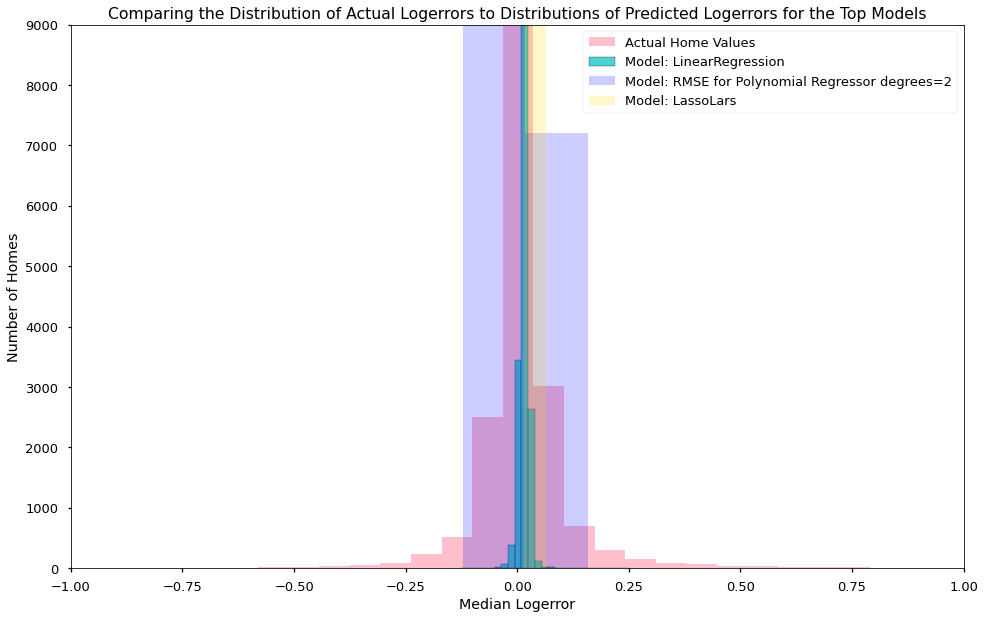

In [89]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,10))
plt.hist(y_validate.logerror, color='pink', alpha=1, bins=100, label="Actual Home Values")
plt.hist(y_validate.logerror_pred_lm, color='c', alpha=.7, bins=25, label="Model: LinearRegression", ec='black')
#plt.hist(y_validate.logerror_pred_lm3, color='chartreuse', alpha=.2, bins=200, label="Model: RMSE for Polynomial Regressor degrees=3")
plt.hist(y_validate.logerror_pred_lm2, color='blue', alpha=.2, bins=200, label="Model: RMSE for Polynomial Regressor degrees=2")
plt.hist(y_validate.logerror_pred_lars, color='gold', alpha=.2, bins=20, label="Model: LassoLars")

plt.xlim(-1, 1)
plt.ylim(0, 9000)
plt.xlabel("Median Logerror")
plt.ylabel("Number of Homes")
plt.title("Comparing the Distribution of Actual Logerrors to Distributions of Predicted Logerrors for the Top Models")
plt.legend()
plt.show()

<div class="alert alert-block alert-warning">   <span style="color:maroon;">




# This is the results of my tests, Im going to test the best which is my Regression Model 

<span style="color:black;">
    

    
    
BASELINE:
              
RMSE using Median
Train/In-Sample: 0.164122
Validate/Out-of-Sample: 0.166928
              
RMSE for OLS using LinearRegression
                
Training/In-Sample: 0.163522
Validation/Out-of-Sample: 0.166431

RMSE for LassoLars
                
Training/In-Sample: 0.163881
Validation/Out-of-Sample: 0.166614

RMSE for Polynomial Regressor degrees=2
        
Training/In-Sample: 0.162717
Validation/Out-of-Sample: 0.227041
                
RMSE for Polynomial Regressor degrees=3
    
Training/In-Sample: 0.158891
Validation/Out-of-Sample: 211.346998     

In [90]:
y_test = pd.DataFrame(y_test)

#predict on test
y_test['logerror_pred_lm'] = lm.predict(X_test_scaled)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.logerror, y_test.logerror_pred_lm)**(0.5)

print(f"""
              BASELINE:
              
              RMSE using Median
              Train/In-Sample: {round(rmse_train, 6)}
              Validate/Out-of-Sample: {round(rmse_validate, 6)}
              
              
    RMSE for OLS using LinearRegression
    
    Test/Out-of-Sample Performance: {round(rmse_test, 6)}
""")


              BASELINE:
              
              RMSE using Median
              Train/In-Sample: 0.164122
              Validate/Out-of-Sample: 0.166928
              
              
    RMSE for OLS using LinearRegression
    
    Test/Out-of-Sample Performance: 0.161771



<div class="alert alert-block alert-warning"> <span style="color:maroon;">



    
## Conclusion 
    
    
<span style="color:black;">
    
- Zillow has done a good job makeing there algorithem to detect logerror and I hope to get better so i can make a bigger dent in the problem. I have gained alot of value from exploring and picking apart the data that was in my supply. I personaly would like to ask for more time from the zillow executive staff to chase down some more leads. The fact is we still improved so I guess we go with small baby steps for now and see what we can do with this information 

    
<span style="color:maroon;">
    
## Recommendations
    
    
<span style="color:black;">    

    
- I feel that I would pay closer attention to the actual cluster centers and try to do some modeling with that information 
- I have gotten in contact with some of our engineers and they say that have been have problesms with the curb-side appraise AI for Old houses, that will be a lead that I will hunt down given more time 
- There has also been a issue reported on fringe neighborhoods example: the outside rung of really wealthy or up and coming neighborhoods are said to produce logerror 
- All of my rough data follow that path, so I would request to be paired up with a senior so they could help explore my findings 

<img src="Logo.jpg"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 20px;" />